In [2]:
import pandas as pd
import numpy as np
import gc

def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

def read_csv(file_path):
    return reduce_mem_usage_sd(pd.read_csv(file_path))

In [3]:
sales = read_csv(r'data/sales.csv')

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mem. usage decreased from 8412.51 Mb to 8004.33 Mb (4.9% reduction)


In [4]:
sales.shape

(19454838, 13)

In [5]:
sales.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,P0001,S0002,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
1,P0001,S0012,2017-01-02,1.0,5.30,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
2,P0001,S0013,2017-01-02,2.0,10.59,0.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
3,P0001,S0023,2017-01-02,0.0,0.00,6.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
4,P0001,S0025,2017-01-02,0.0,0.00,1.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN


In [6]:
taxonomy = read_csv(r'data/product_taxonomy.csv')

Mem. usage decreased from  0.31 Mb to  0.31 Mb (2.6% reduction)


In [7]:
taxonomy.tail()

,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
694,P0744,2.0,7.0,7.000000,NaN,H03,H0311,H031108,H03110802,H0311080202
695,P0745,NaN,NaN,NaN,cluster_0,H02,H0209,H020908,H02090804,H0209080422
696,P0746,1.0,1.0,1.000000,cluster_0,H03,H0314,H031407,H03140702,H0314070202
697,P0747,23.0,23.0,33.299999,cluster_0,H01,H0107,H010701,H01070100,H0107010026
698,P0748,3.8,4.8,15.300000,cluster_0,H01,H0108,H010801,H01080110,H0108011006


In [8]:
taxonomy.hierarchy1_id.value_counts()

H03    292
H00    215
H01    181
H02     11
Name: hierarchy1_id, dtype: int64

In [9]:
taxonomy.groupby('hierarchy1_id')['product_id'].nunique()

hierarchy1_id
H00    215
H01    181
H02     11
H03    292
Name: product_id, dtype: int64

In [10]:
taxonomy.shape

(699, 10)

In [11]:
stores = read_csv(r'data/store_cities.csv')

Mem. usage decreased from  0.03 Mb to  0.03 Mb (3.6% reduction)


In [12]:
stores.shape

(144, 4)

In [13]:
stores.head()

,store_id,storetype_id,store_size,city_id
0,S0091,ST04,19,C013
1,S0012,ST04,28,C005
2,S0045,ST04,17,C008
3,S0032,ST03,14,C019
4,S0027,ST04,24,C022


In [14]:
sales.dtypes, taxonomy.dtypes, stores.dtypes

(product_id                object
 store_id                  object
 date                      object
 sales                    float32
 revenue                  float32
 stock                    float32
 price                    float32
 promo_type_1              object
 promo_bin_1               object
 promo_type_2              object
 promo_bin_2               object
 promo_discount_2         float16
 promo_discount_type_2     object
 dtype: object,
 product_id         object
 product_length    float32
 product_depth     float32
 product_width     float32
 cluster_id         object
 hierarchy1_id      object
 hierarchy2_id      object
 hierarchy3_id      object
 hierarchy4_id      object
 hierarchy5_id      object
 dtype: object,
 store_id        object
 storetype_id    object
 store_size        int8
 city_id         object
 dtype: object)

In [15]:
# sales['product_id'] = sales['product_id'].astype(str)
# taxonomy['product_id'] = taxonomy['product_id'].astype(str)

# sales['store_id'] = sales['store_id'].astype(str)
# stores['store_id'] = stores['store_id'].astype(str)

In [16]:
data = pd.merge(sales, taxonomy, how='inner', on = ['product_id'])\
         .merge(stores, how='inner', on = ['store_id'])

In [17]:
data.shape[0] == sales.shape[0]

True

In [18]:
data.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,...,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_id
0,P0001,S0002,2017-01-02,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007
1,P0001,S0002,2017-01-03,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007
2,P0001,S0002,2017-01-04,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007
3,P0001,S0002,2017-01-05,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007
4,P0001,S0002,2017-01-06,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006,ST04,39,C007


In [19]:
del sales, taxonomy, stores
gc.collect()

100

In [20]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [21]:
data['month_year'] = pd.to_datetime(data['date']).dt.to_period('M')

In [22]:
gr = data.groupby(['date', 'hierarchy1_id', 'storetype_id'])['sales'].sum().reset_index()

In [23]:
gr.head()

,date,hierarchy1_id,storetype_id,sales
0,2017-01-02,H00,ST01,767.294006
1,2017-01-02,H00,ST02,232.225998
2,2017-01-02,H00,ST03,899.000000
3,2017-01-02,H00,ST04,3458.251953
4,2017-01-02,H01,ST01,155.000000


In [24]:
gr.shape

(16845, 4)

In [25]:
gr.groupby('hierarchy1_id')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
hierarchy1_id,,,,,,,,
H00,4368.0,1403.714478,1847.393799,0.0,222.708508,822.000,1325.948029,47103.632812
H01,4368.0,202.095245,339.952850,0.0,32.000000,63.000,223.000000,6870.000000
H02,3741.0,20.375763,41.467800,0.0,0.170000,4.608,14.868000,614.040039
H03,4368.0,200.596848,288.076233,0.0,31.000000,80.000,331.250000,2101.000000


In [26]:
gr.shape

(16845, 4)

# Time features

In [27]:
### CYCLICAL ENCODING VARIABLES ###

def cyclic_encoding(df, col):
    
    max_val = df[col].max()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    
    return df.drop([col], axis=1)


data['DayOfWeek'] = data.date.dt.dayofweek
data = cyclic_encoding(data, 'DayOfWeek')
data['WeekOfYear'] = data.date.dt.isocalendar().week
data = cyclic_encoding(data, 'WeekOfYear')
data['Month'] = data.date.dt.month
data = cyclic_encoding(data, 'Month')
data['Season'] = data.date.dt.quarter
data = cyclic_encoding(data, 'Season')

In [28]:
data.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,...,city_id,month_year,DayOfWeek_sin,DayOfWeek_cos,WeekOfYear_sin,WeekOfYear_cos,Month_sin,Month_cos,Season_sin,Season_cos
0,P0001,S0002,2017-01-02,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,C007,2017-01,0.000000e+00,1.0,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
1,P0001,S0002,2017-01-03,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,C007,2017-01,8.660254e-01,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
2,P0001,S0002,2017-01-04,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,C007,2017-01,8.660254e-01,-0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
3,P0001,S0002,2017-01-05,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,C007,2017-01,1.224647e-16,-1.0,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
4,P0001,S0002,2017-01-06,0.0,0.0,8.0,6.25,PR14,NaN,PR03,...,C007,2017-01,-8.660254e-01,-0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17


In [29]:
data.columns

Index(['product_id', 'store_id', 'date', 'sales', 'revenue', 'stock', 'price',
       'promo_type_1', 'promo_bin_1', 'promo_type_2', 'promo_bin_2',
       'promo_discount_2', 'promo_discount_type_2', 'product_length',
       'product_depth', 'product_width', 'cluster_id', 'hierarchy1_id',
       'hierarchy2_id', 'hierarchy3_id', 'hierarchy4_id', 'hierarchy5_id',
       'storetype_id', 'store_size', 'city_id', 'month_year', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'WeekOfYear_sin', 'WeekOfYear_cos', 'Month_sin',
       'Month_cos', 'Season_sin', 'Season_cos'],
      dtype='object')

In [36]:
gr = data.groupby(['storetype_id', 'hierarchy1_id'])['date'].nunique()    

In [38]:
gr.describe([.1, .2, .3, .4, .5, .6, .7, .8, .9, .95])

count      16.000000
mean     1052.812500
std       122.905502
min       610.000000
10%      1019.500000
20%      1092.000000
30%      1092.000000
40%      1092.000000
50%      1092.000000
60%      1092.000000
70%      1092.000000
80%      1092.000000
90%      1092.000000
95%      1092.000000
max      1092.000000
Name: date, dtype: float64

In [40]:
gr.head()

storetype_id  hierarchy1_id
ST01          H00              1092
              H01              1092
              H02               955
              H03              1092
ST02          H00              1092
Name: date, dtype: int64

# Prophet

In [73]:
from fbprophet import Prophet
import datetime
from sklearn.metrics import mean_squared_error as mse

In [52]:
train = data[data.date < datetime.datetime(2019, 10, 1)]

In [53]:
test = data[data.date.between(datetime.datetime(2019, 10, 1), datetime.datetime(2019, 10, 31))]

In [54]:
del data
gc.collect()

200

In [55]:
train_series = train[(train.storetype_id == 'ST01') & (train.hierarchy1_id == 'H00')].groupby('date')['sales'].sum().reset_index()\
         .sort_values(by='date', ascending=True)

In [57]:
test_series = test[(test.storetype_id == 'ST01') & (test.hierarchy1_id == 'H00')].groupby('date')['sales'].sum().reset_index()\
         .sort_values(by='date', ascending=True)

In [118]:
prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, 
                  yearly_seasonality=False, changepoint_prior_scale=0.01)
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=1)
prophet.fit(train_series.rename(columns={'date' : 'ds', 'sales' : 'y'}))

In [119]:
preds = prophet.predict(test_series.reset_index().rename(columns={'date':'ds'}).drop('sales', axis=1))
preds = preds[['ds','yhat']].rename(columns={'ds':'Date'}).set_index('Date')['yhat']

In [120]:
print('\n', 'TEST ERROR:', mse(test_series['sales'], preds, squared=False))


 TEST ERROR: 106.49480551346275


In [121]:
import matplotlib.pyplot as plt

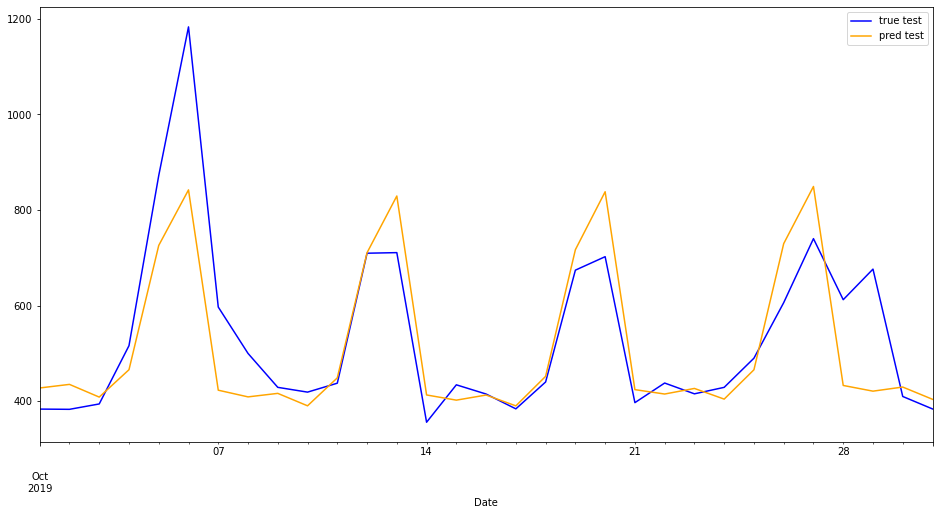

In [122]:
### PLOT PROPHET PREDICTIONS ###

test_series.set_index('date')['sales'].plot(figsize=(16,8), label='true test', c='blue')
preds.plot(figsize=(16,8), label='pred test', c='orange')
plt.legend()

In [123]:
p = prophet.predict(train_series.reset_index().rename(columns={'date':'ds'}).drop('sales', axis=1))

In [125]:
p

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,788.231586,572.413536,1004.120798,788.231586,788.231586,-17.959893,-17.959893,-17.959893,84.065639,...,-0.745209,-0.745209,-0.745209,-101.280322,-101.280322,-101.280322,0.0,0.0,0.0,770.271694
1,2017-01-03,787.879058,534.219711,978.672641,787.879058,787.879058,-31.868972,-31.868972,-31.868972,84.065639,...,-3.277487,-3.277487,-3.277487,-112.657124,-112.657124,-112.657124,0.0,0.0,0.0,756.010086
2,2017-01-04,787.526530,536.366524,998.809870,787.526530,787.526530,-24.576353,-24.576353,-24.576353,84.065639,...,-5.671165,-5.671165,-5.671165,-102.970827,-102.970827,-102.970827,0.0,0.0,0.0,762.950177
3,2017-01-05,787.174001,510.427352,941.097433,787.174001,787.174001,-50.799195,-50.799195,-50.799195,84.065639,...,-7.825016,-7.825016,-7.825016,-127.039817,-127.039817,-127.039817,0.0,0.0,0.0,736.374806
4,2017-01-06,786.821473,574.447992,1027.195752,786.821473,786.821473,7.376936,7.376936,7.376936,84.065639,...,-9.647959,-9.647959,-9.647959,-67.040744,-67.040744,-67.040744,0.0,0.0,0.0,794.198409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,2019-09-26,448.454669,194.031120,626.105983,448.454669,448.454669,-31.154538,-31.154538,-31.154538,84.065639,...,11.819641,11.819641,11.819641,-127.039817,-127.039817,-127.039817,0.0,0.0,0.0,417.300132
998,2019-09-27,448.118469,254.717137,688.438618,448.118469,448.118469,29.413330,29.413330,29.413330,84.065639,...,12.388435,12.388435,12.388435,-67.040744,-67.040744,-67.040744,0.0,0.0,0.0,477.531799
999,2019-09-28,447.782268,529.138147,963.594113,447.782268,447.782268,292.431801,292.431801,292.431801,84.065639,...,12.433339,12.433339,12.433339,195.932823,195.932823,195.932823,0.0,0.0,0.0,740.214069
1000,2019-09-29,447.446068,637.051070,1069.185968,447.446068,447.446068,411.074104,411.074104,411.074104,84.065639,...,11.952455,11.952455,11.952455,315.056011,315.056011,315.056011,0.0,0.0,0.0,858.520172
